# CarbonWatch: Carbon Transaction Classification Model

This notebook implements a machine learning pipeline for classifying carbon credit transactions using TensorFlow/Keras. The model classifies transactions into three categories:
- **Verified**: Legitimate carbon credit transactions
- **Caution**: Transactions requiring review
- **High-Risk**: Potentially fraudulent transactions

## Pipeline Overview
1. Data loading and cleaning
2. Feature preprocessing and encoding
3. Neural network model building
4. Model training with early stopping
5. Model evaluation and saving

## 1. Import Libraries and Set Up Environment

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import os

# Menonaktifkan log TensorFlow yang kurang relevan
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.20.0


## 2. Load and Clean Data

Define function to load the dataset from CSV file and handle missing values through imputation.

In [2]:
def load_and_clean_data(filepath):
    """
    Memuat dataset dari filepath, membersihkan data, dan menanganani nilai yang hilang.
    """
    print("\n--- Memulai Pemuatan dan Pembersihan Data ---")
    df = pd.read_csv(filepath)

    # Mengatasi inkonsistensi data (contoh: 'PT.' menjadi 'PT')
    if 'Entity Type' in df.columns:
        df['Entity Type'] = df['Entity Type'].str.replace('.', '', regex=False)

    # Imputasi untuk nilai numerik yang hilang (NaN) dengan median
    numeric_cols = df.select_dtypes(include=np.number).columns
    imputer_numeric = SimpleImputer(strategy='median')
    df[numeric_cols] = imputer_numeric.fit_transform(df[numeric_cols])
    print("Nilai numerik yang hilang telah diisi dengan median.")

    # Imputasi untuk nilai kategorikal yang hilang (NaN) dengan modus
    categorical_cols = df.select_dtypes(include='object').columns.drop('Label')
    imputer_categorical = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = imputer_categorical.fit_transform(df[categorical_cols])
    print("Nilai kategorikal yang hilang telah diisi dengan modus.")
    
    print("--- Pembersihan Data Selesai ---")
    return df

In [3]:
# Load and clean the dataset
dataset_path = 'dummy.csv'
if not os.path.exists(dataset_path):
    print(f"Error: File '{dataset_path}' tidak ditemukan. Pastikan file tersebut ada di direktori yang sama.")
else:
    cleaned_df = load_and_clean_data(dataset_path)
    print(f"Dataset loaded with shape: {cleaned_df.shape}")
    print(f"Columns: {list(cleaned_df.columns)}")
    print(f"Label distribution:\n{cleaned_df['Label'].value_counts()}")


--- Memulai Pemuatan dan Pembersihan Data ---
Nilai numerik yang hilang telah diisi dengan median.
Nilai kategorikal yang hilang telah diisi dengan modus.
--- Pembersihan Data Selesai ---
Dataset loaded with shape: (1000, 18)
Columns: ['Transaction Amount', 'Carbon Volume', 'Price per Ton', 'Origin Country', 'Cross-Border Flag', 'Buyer Industry', 'Sudden Transaction Spike', 'Transaction Hour', 'Entity Type', 'Label', 'company id', 'nama perusahaan', 'Nama Perusahaan', 'Sektor Perusahaan', 'Alamat', 'Kontak', 'NPWP', 'Situs Web']
Label distribution:
Label
Normal        700
Suspicious    200
Red-Flag      100
Name: count, dtype: int64


## 3. Preprocess Data

Separate features and labels, encode target labels, and set up preprocessing transformers for numerical and categorical features.

In [4]:
def preprocess_data(df):
    """
    Memisahkan fitur dan label, melakukan encoding dan scaling.
    """
    print("\n--- Memulai Pra-pemrosesan Data ---")
    # Memilih fitur (X) dari daftar kolom yang diinginkan dan label (y)
    feature_cols = [
        'Transaction Amount', 'Carbon Volume', 'Price per Ton', 'Origin Country',
        'Cross-Border Flag', 'Buyer Industry', 'Sudden Transaction Spike',
        'Transaction Hour', 'Entity Type'
    ]
    # Periksa apakah semua kolom fitur ada di dataframe
    missing_cols = [c for c in feature_cols if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing expected feature columns: {missing_cols}")
    X = df[feature_cols]
    y = df['Label']

    # Encoding label target (Verified, Caution, High-Risk -> 0, 1, 2)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    # Mengubah ke format one-hot untuk TensorFlow
    y_categorical = tf.keras.utils.to_categorical(y_encoded)
    
    # Menyiapkan transformer untuk kolom numerik dan kategorikal
    numeric_features = X.select_dtypes(include=np.number).columns
    categorical_features = X.select_dtypes(include=['object', 'bool']).columns

    preprocessor = make_column_transformer(
        (StandardScaler(), numeric_features),
        (OneHotEncoder(handle_unknown='ignore'), categorical_features)
    )
    
    print("Fitur numerik akan di-scale, fitur kategorikal akan di-encode.")
    print("--- Pra-pemrosesan Selesai ---")
    return X, y_categorical, preprocessor, label_encoder

In [5]:
# Apply preprocessing
X, y, preprocessor, le = preprocess_data(cleaned_df)
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Label classes: {le.classes_}")


--- Memulai Pra-pemrosesan Data ---
Fitur numerik akan di-scale, fitur kategorikal akan di-encode.
--- Pra-pemrosesan Selesai ---
Features shape: (1000, 9)
Labels shape: (1000, 3)
Label classes: ['Normal' 'Red-Flag' 'Suspicious']


## 4. Split Data into Training and Testing Sets

Use stratified train-test split to ensure balanced representation of each class in both training and testing sets.

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set - Features: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing set - Features: {X_test.shape}, Labels: {y_test.shape}")
print(f"Training labels distribution:\n{pd.Series(y_train.argmax(axis=1)).value_counts()}")
print(f"Testing labels distribution:\n{pd.Series(y_test.argmax(axis=1)).value_counts()}")

Training set - Features: (800, 9), Labels: (800, 3)
Testing set - Features: (200, 9), Labels: (200, 3)
Training labels distribution:
0    560
2    160
1     80
Name: count, dtype: int64
Testing labels distribution:
0    140
2     40
1     20
Name: count, dtype: int64


## 5. Apply Preprocessing to Data

Fit the preprocessor on training data and transform both training and testing sets to prepare them for the neural network.

In [7]:
# Apply preprocessing transformations
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training features shape: {X_train_processed.shape}")
print(f"Processed testing features shape: {X_test_processed.shape}")
print(f"Input dimension for neural network: {X_train_processed.shape[1]}")

Processed training features shape: (800, 34)
Processed testing features shape: (200, 34)
Input dimension for neural network: 34


In [8]:
# Inspeksi kolom yang digunakan setelah preprocessing
print("🔍 Inspeksi Kolom yang Digunakan:")
print("=" * 50)

# Kolom asli yang dipilih
original_features = [
    'Transaction Amount', 'Carbon Volume', 'Price per Ton', 'Origin Country',
    'Cross-Border Flag', 'Buyer Industry', 'Sudden Transaction Spike',
    'Transaction Hour', 'Entity Type'
]

print("📊 Kolom asli yang dipilih:")
for i, col in enumerate(original_features, 1):
    print(f"  {i}. {col}")

# Kolom numerik dan kategorikal
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

print(f"\n🔢 Kolom numerik ({len(numeric_features)}):")
for i, col in enumerate(numeric_features, 1):
    print(f"  {i}. {col}")

print(f"\n📝 Kolom kategorikal ({len(categorical_features)}):")
for i, col in enumerate(categorical_features, 1):
    print(f"  {i}. {col}")

# Setelah preprocessing, cek dimensi output
print(f"\n📈 Dimensi setelah preprocessing:")
print(f"  Input original: {X.shape}")
print(f"  Output processed: {X_train_processed.shape}")
print(f"  Total features after encoding: {X_train_processed.shape[1]}")

# Informasi tentang transformasi
print(f"\n⚙️ Transformasi yang diterapkan:")
print("  - Kolom numerik: StandardScaler (normalisasi)")
print("  - Kolom kategorikal: OneHotEncoder (encoding)")
print("  - Hasil: Sparse matrix → Dense array untuk neural network")

🔍 Inspeksi Kolom yang Digunakan:
📊 Kolom asli yang dipilih:
  1. Transaction Amount
  2. Carbon Volume
  3. Price per Ton
  4. Origin Country
  5. Cross-Border Flag
  6. Buyer Industry
  7. Sudden Transaction Spike
  8. Transaction Hour
  9. Entity Type

🔢 Kolom numerik (4):
  1. Transaction Amount
  2. Carbon Volume
  3. Price per Ton
  4. Transaction Hour

📝 Kolom kategorikal (5):
  1. Origin Country
  2. Cross-Border Flag
  3. Buyer Industry
  4. Sudden Transaction Spike
  5. Entity Type

📈 Dimensi setelah preprocessing:
  Input original: (1000, 9)
  Output processed: (800, 34)
  Total features after encoding: 34

⚙️ Transformasi yang diterapkan:
  - Kolom numerik: StandardScaler (normalisasi)
  - Kolom kategorikal: OneHotEncoder (encoding)
  - Hasil: Sparse matrix → Dense array untuk neural network


## 6. Build Neural Network Model

Create a Sequential Keras model with dense layers, dropout for regularization, and softmax output for multi-class classification.

In [9]:
def build_model(input_shape):
    """
    Membangun arsitektur model neural network dengan TensorFlow/Keras.
    """
    print("\n--- Membangun Model Jaringan Saraf Tiruan ---")
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax') # 3 kelas output (Verified, Caution, High-Risk)
    ])

    # Mengompilasi model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()
    return model

In [10]:
# Build the model
input_dim = X_train_processed.shape[1]
model = build_model(input_dim)


--- Membangun Model Jaringan Saraf Tiruan ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,915 (58.26 KB)

 Trainable params: 14,915 (58.26 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Train Model

Train the neural network using the training data with early stopping callback to prevent overfitting.

In [11]:
# Set up early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
print("\n--- Memulai Pelatihan Model ---")
history = model.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
print("--- Pelatihan Model Selesai ---")


--- Memulai Pelatihan Model ---
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6687 - loss: 0.8918 - val_accuracy: 0.6875 - val_loss: 0.6930
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7406 - loss: 0.5438 - val_accuracy: 0.7875 - val_loss: 0.4179
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8797 - loss: 0.3460 - val_accuracy: 0.9312 - val_loss: 0.2561
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9469 - loss: 0.2096 - val_accuracy: 0.9563 - val_loss: 0.1538
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9656 - loss: 0.1451 - val_accuracy: 0.9750 - val_loss: 0.0983
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9766 - loss: 0.0988 - val_accuracy: 0.9812 - val_loss: 0.0684
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9875 - loss: 0.0580 - val_accuracy: 0.9750 - val_loss: 0.0718
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9891 - loss:

## 8. Evaluate Model

Evaluate the trained model on the test set to measure its performance on unseen data.

In [12]:
# Evaluate the model on test data
print("\n--- Mengevaluasi Model pada Data Test ---")
loss, accuracy = model.evaluate(X_test_processed, y_test)
print(f"Akurasi Model: {accuracy * 100:.2f}%")
print(f"Loss Model: {loss:.4f}")

# Make predictions on test set
predictions = model.predict(X_test_processed)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Display some sample predictions
print(f"\nBeberapa contoh prediksi:")
for i in range(5):
    true_label = le.classes_[true_classes[i]]
    pred_label = le.classes_[predicted_classes[i]]
    confidence = np.max(predictions[i]) * 100
    print(f"Sample {i+1}: True={true_label}, Predicted={pred_label}, Confidence={confidence:.1f}%")


--- Mengevaluasi Model pada Data Test ---
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0038  
Akurasi Model: 100.00%
Loss Model: 0.0038
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Beberapa contoh prediksi:
Sample 1: True=Suspicious, Predicted=Suspicious, Confidence=100.0%
Sample 2: True=Normal, Predicted=Normal, Confidence=100.0%
Sample 3: True=Normal, Predicted=Normal, Confidence=100.0%
Sample 4: True=Normal, Predicted=Normal, Confidence=100.0%
Sample 5: True=Normal, Predicted=Normal, Confidence=88.0%


## 8.1. Model Performance Visualization

Visualize training history, confusion matrix, and other metrics to analyze model performance and detect overfitting.

In [13]:
# Import additional libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

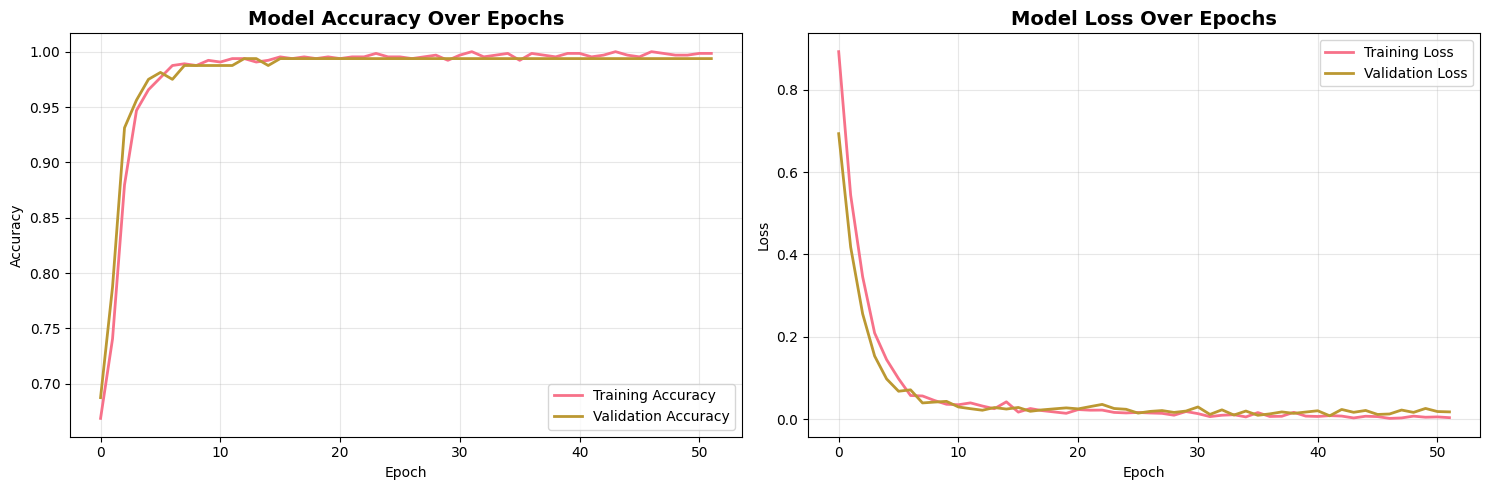


📊 Analisis Overfitting:
Training Accuracy: 0.9984
Validation Accuracy: 0.9937
Training Loss: 0.0043
Validation Loss: 0.0183
✅ Model terlihat tidak overfitting.


In [14]:
# Plot training history to check for overfitting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot training & validation loss
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze overfitting
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📊 Analisis Overfitting:")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")

acc_diff = abs(final_train_acc - final_val_acc)
loss_diff = abs(final_val_loss - final_train_loss)

if acc_diff > 0.05 or loss_diff > 0.1:
    print("⚠️  Model menunjukkan tanda-tanda overfitting!")
else:
    print("✅ Model terlihat tidak overfitting.")

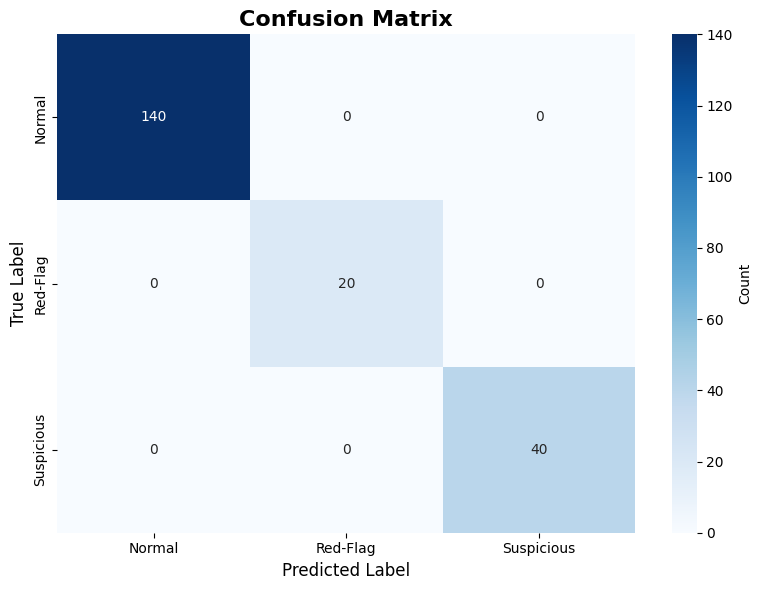


📋 Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       140
    Red-Flag       1.00      1.00      1.00        20
  Suspicious       1.00      1.00      1.00        40

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


📈 Weighted Average Metrics:
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [15]:
# Create and visualize confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate per-class metrics
print("\n📋 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=le.classes_))

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"\n📈 Weighted Average Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

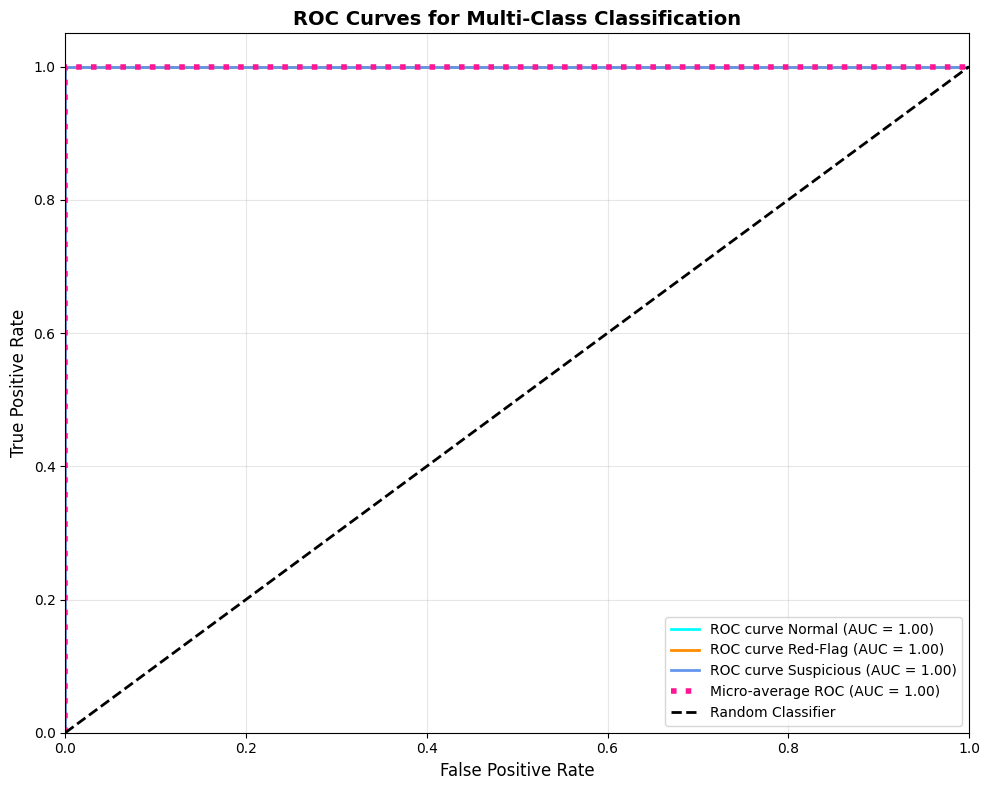


🎯 AUC Scores per Class:
Normal: 1.0000
Red-Flag: 1.0000
Suspicious: 1.0000
Micro-average: 1.0000


In [16]:
# ROC Curve for multi-class classification
# Binarize the output for ROC calculation
y_test_bin = label_binarize(true_classes, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Multi-Class Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 AUC Scores per Class:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name}: {roc_auc[i]:.4f}")
print(f"Micro-average: {roc_auc['micro']:.4f}")

C:\Users\ACER\AppData\Local\Temp\ipykernel_10164\434495543.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([confidence_by_class[class_name] for class_name in le.classes_],


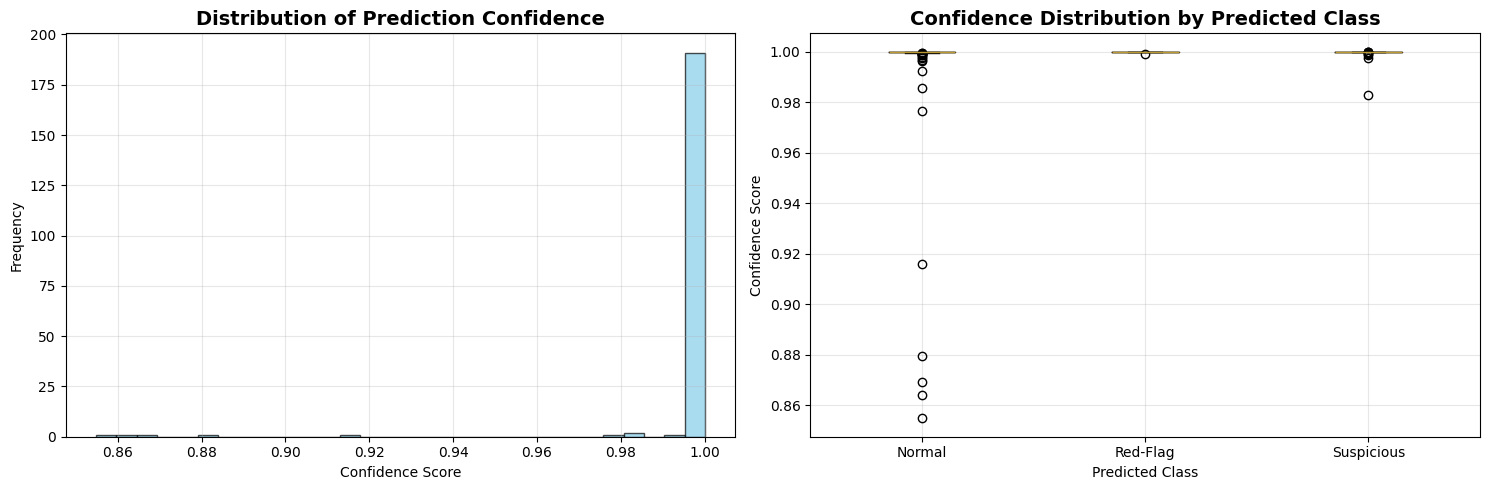


🎯 Confidence Statistics:
Mean Confidence: 0.9964
Median Confidence: 1.0000
Min Confidence: 0.8549
Max Confidence: 1.0000

⚠️  Predictions with low confidence (<0.6):
Count: 0 out of 200 (0.0%)


In [17]:
# Analyze prediction confidence distribution
confidence_scores = np.max(predictions, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Overall confidence distribution
ax1.hist(confidence_scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Prediction Confidence', fontsize=14, fontweight='bold')
ax1.set_xlabel('Confidence Score')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Confidence by class
confidence_by_class = {}
for i, class_name in enumerate(le.classes_):
    class_mask = predicted_classes == i
    confidence_by_class[class_name] = confidence_scores[class_mask]

ax2.boxplot([confidence_by_class[class_name] for class_name in le.classes_], 
           labels=le.classes_)
ax2.set_title('Confidence Distribution by Predicted Class', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Class')
ax2.set_ylabel('Confidence Score')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print confidence statistics
print(f"\n🎯 Confidence Statistics:")
print(f"Mean Confidence: {np.mean(confidence_scores):.4f}")
print(f"Median Confidence: {np.median(confidence_scores):.4f}")
print(f"Min Confidence: {np.min(confidence_scores):.4f}")
print(f"Max Confidence: {np.max(confidence_scores):.4f}")

# Low confidence predictions (potential uncertain cases)
low_confidence_threshold = 0.6
low_conf_mask = confidence_scores < low_confidence_threshold
num_low_conf = np.sum(low_conf_mask)

print(f"\n⚠️  Predictions with low confidence (<{low_confidence_threshold}):")
print(f"Count: {num_low_conf} out of {len(confidence_scores)} ({num_low_conf/len(confidence_scores)*100:.1f}%)")

if num_low_conf > 0:
    print(f"Classes with low confidence predictions:")
    low_conf_classes = predicted_classes[low_conf_mask]
    for class_idx in np.unique(low_conf_classes):
        count = np.sum(low_conf_classes == class_idx)
        print(f"  {le.classes_[class_idx]}: {count} predictions")

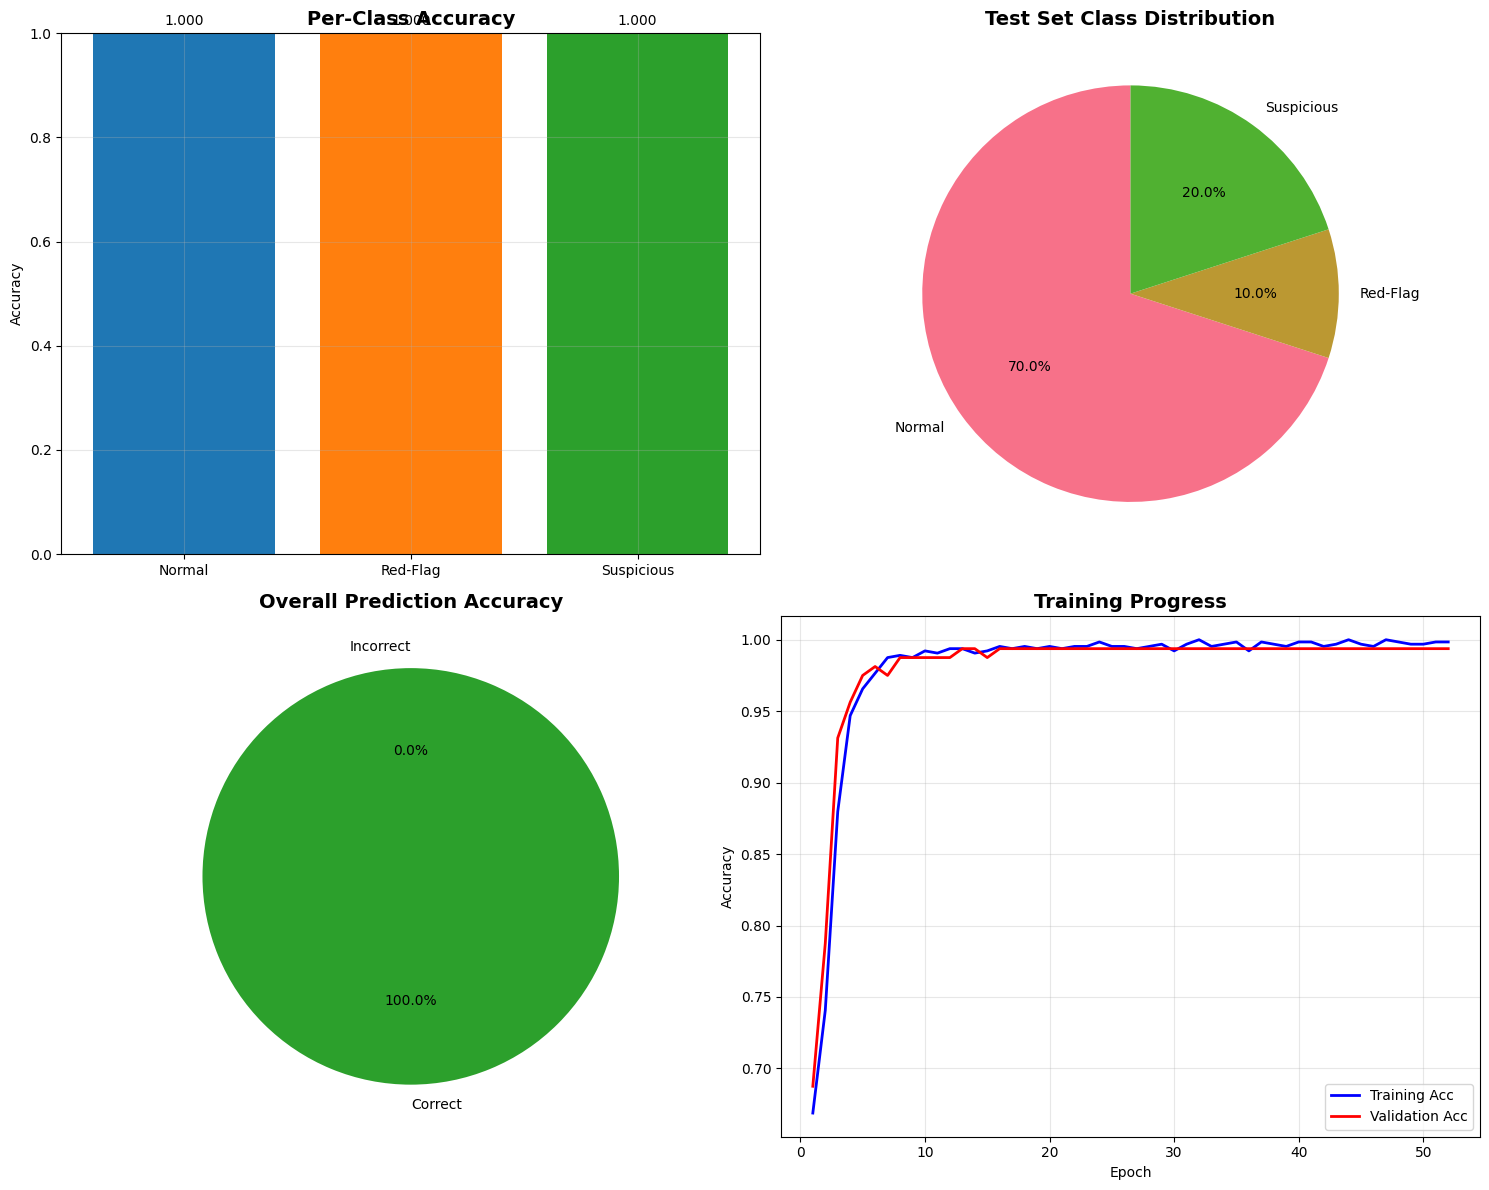

📊 MODEL PERFORMANCE SUMMARY
Overall Test Accuracy: 1.0000 (100.00%)
Overall Test Loss: 0.0038
Total Test Samples: 200
Training Epochs: 52

Per-Class Performance:
  Normal: 1.0000 (100.00%)
  Red-Flag: 1.0000 (100.00%)
  Suspicious: 1.0000 (100.00%)

Model Confidence:
  Average Confidence: 0.9964
  Low Confidence Predictions: 0/200 (0.0%)


In [18]:
# Model Performance Summary
def create_performance_summary():
    """Create a comprehensive performance summary"""
    
    # Calculate per-class accuracy
    per_class_acc = {}
    for i, class_name in enumerate(le.classes_):
        mask = true_classes == i
        if np.sum(mask) > 0:
            correct = np.sum((true_classes == i) & (predicted_classes == i))
            total = np.sum(mask)
            per_class_acc[class_name] = correct / total
    
    # Create summary visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Per-class accuracy
    classes = list(per_class_acc.keys())
    accuracies = list(per_class_acc.values())
    bars1 = ax1.bar(classes, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax1.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    ax1.grid(True, alpha=0.3)
    
    # 2. Class distribution in test set
    unique, counts = np.unique(true_classes, return_counts=True)
    class_names = [le.classes_[i] for i in unique]
    ax2.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
    
    # 3. Correct vs Incorrect predictions
    correct_mask = true_classes == predicted_classes
    correct_count = np.sum(correct_mask)
    incorrect_count = len(true_classes) - correct_count
    
    ax3.pie([correct_count, incorrect_count], 
           labels=['Correct', 'Incorrect'], 
           colors=['#2ca02c', '#d62728'],
           autopct='%1.1f%%', startangle=90)
    ax3.set_title('Overall Prediction Accuracy', fontsize=14, fontweight='bold')
    
    # 4. Training epochs vs performance
    epochs = range(1, len(history.history['accuracy']) + 1)
    ax4.plot(epochs, history.history['accuracy'], 'b-', label='Training Acc', linewidth=2)
    ax4.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Acc', linewidth=2)
    ax4.set_title('Training Progress', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("="*60)
    print("📊 MODEL PERFORMANCE SUMMARY")
    print("="*60)
    print(f"Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Overall Test Loss: {loss:.4f}")
    print(f"Total Test Samples: {len(y_test)}")
    print(f"Training Epochs: {len(history.history['accuracy'])}")
    print("\nPer-Class Performance:")
    for class_name, acc in per_class_acc.items():
        print(f"  {class_name}: {acc:.4f} ({acc*100:.2f}%)")
    
    print(f"\nModel Confidence:")
    print(f"  Average Confidence: {np.mean(confidence_scores):.4f}")
    print(f"  Low Confidence Predictions: {num_low_conf}/{len(confidence_scores)} ({num_low_conf/len(confidence_scores)*100:.1f}%)")

create_performance_summary()

## 9. Save Trained Model

Save the trained model to disk for future use and deployment.

In [19]:
# Save the trained model
model_filename = 'carbon_watch_model.keras'
model.save(model_filename)
print(f"\n--- Model telah berhasil disimpan sebagai '{model_filename}' ---")

# Also save the preprocessor and label encoder for future use
import pickle

with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Preprocessor dan Label Encoder juga telah disimpan untuk penggunaan masa depan.")


--- Model telah berhasil disimpan sebagai 'carbon_watch_model.keras' ---
Preprocessor dan Label Encoder juga telah disimpan untuk penggunaan masa depan.


## Conclusion

The CarbonWatch model has been successfully trained and evaluated. The pipeline includes:

1. ✅ **Data Loading & Cleaning**: Handled missing values and data inconsistencies
2. ✅ **Feature Preprocessing**: Applied scaling to numerical features and encoding to categorical features  
3. ✅ **Model Architecture**: Built a neural network with dropout layers for regularization
4. ✅ **Training**: Used early stopping to prevent overfitting
5. ✅ **Evaluation**: Assessed model performance on test data
6. ✅ **Model Persistence**: Saved the trained model, preprocessor, and label encoder

The model is now ready to classify carbon credit transactions into three categories:
- **Verified**: Legitimate transactions
- **Caution**: Transactions requiring review
- **High-Risk**: Potentially fraudulent transactions

### Next Steps
- Deploy the model for real-time transaction monitoring
- Implement model monitoring and retraining procedures
- Add additional features or ensemble methods to improve performance

## 10. Model Explainability - Prediction with Reasoning

Implement functionality to provide explanations for model predictions, helping users understand why a transaction is classified in a certain way.

In [20]:
def get_feature_importance_explanation(model, X_sample, preprocessor, label_encoder, feature_names):
    """
    Menganalisis pentingnya fitur untuk memberikan penjelasan prediksi
    """
    # Transform the sample - ensure it's a DataFrame
    if isinstance(X_sample, np.ndarray):
        X_sample_df = pd.DataFrame(X_sample.reshape(1, -1), columns=feature_names)
    else:
        X_sample_df = X_sample.reshape(1, -1)
    
    X_processed = preprocessor.transform(X_sample_df)
    
    # Convert sparse matrix to dense if needed
    if hasattr(X_processed, 'toarray'):
        X_processed = X_processed.toarray()
    
    # Get prediction
    prediction = model.predict(X_processed)
    predicted_class = np.argmax(prediction)
    predicted_label = label_encoder.classes_[predicted_class]
    confidence = np.max(prediction) * 100
    
    # Simple feature importance based on input values (simplified approach)
    # For more complex importance, we could use SHAP or LIME
    importance_scores = np.abs(X_processed[0])  # Simple absolute value approach
    
    return {
        'predicted_label': predicted_label,
        'confidence': confidence,
        'prediction_probs': prediction[0],
        'feature_importance': importance_scores
    }

def generate_explanation(sample_data, feature_names, analysis_result, risk_thresholds):
    """
    Generate human-readable explanation based on feature analysis
    """
    predicted_label = analysis_result['predicted_label']
    confidence = analysis_result['confidence']
    
    # Get top important features
    importance_scores = analysis_result['feature_importance']
    
    # Map back to original features (before preprocessing)
    original_features = feature_names
    
    explanation = {
        'prediction': predicted_label,
        'confidence': f"{confidence:.1f}%",
        'reasons': [],
        'risk_indicators': []
    }
    
    # Analyze each original feature
    for i, feature_name in enumerate(original_features):
        feature_value = sample_data.iloc[0, i] if hasattr(sample_data, 'iloc') else sample_data[i]
        
        # Generate specific explanations based on feature values
        if feature_name == 'Transaction Amount':
            if feature_value > 1000000:  # High amount
                explanation['reasons'].append(f"Jumlah transaksi sangat tinggi: ${feature_value:,.2f}")
            elif feature_value < 1000:  # Very low amount
                explanation['reasons'].append(f"Jumlah transaksi sangat rendah: ${feature_value:,.2f}")
                
        elif feature_name == 'Price per Ton':
            market_price_range = (10, 50)  # Typical carbon credit price range
            if feature_value < market_price_range[0]:
                explanation['reasons'].append(f"Harga per ton sangat rendah: ${feature_value:.2f} (di bawah harga pasar normal)")
            elif feature_value > market_price_range[1] * 2:
                explanation['reasons'].append(f"Harga per ton sangat tinggi: ${feature_value:.2f} (jauh di atas harga pasar)")
                
        elif feature_name == 'Carbon Volume':
            if feature_value > 100000:  # Very high volume
                explanation['reasons'].append(f"Volume karbon sangat besar: {feature_value:,.0f} ton")
            elif feature_value < 10:  # Very low volume
                explanation['reasons'].append(f"Volume karbon sangat kecil: {feature_value:.1f} ton")
                
        elif feature_name == 'Cross-Border Flag':
            if feature_value == 1:
                explanation['reasons'].append("Transaksi lintas negara memerlukan verifikasi tambahan")
                
        elif feature_name == 'Sudden Transaction Spike':
            if feature_value == 1:
                explanation['risk_indicators'].append("Terdeteksi lonjakan transaksi mendadak dari entitas ini")
                
        elif feature_name == 'Transaction Hour':
            if feature_value < 6 or feature_value > 22:  # Outside business hours
                explanation['risk_indicators'].append(f"Transaksi di luar jam kerja normal: {int(feature_value)}:00")
                
        elif feature_name == 'Origin Country':
            high_risk_countries = ['Unknown', 'Unverified']
            if feature_value in high_risk_countries:
                explanation['risk_indicators'].append(f"Negara asal tidak terverifikasi: {feature_value}")
                
        elif feature_name == 'Buyer Industry':
            if feature_value == 'Unknown':
                explanation['risk_indicators'].append("Industri pembeli tidak diketahui")
                
        elif feature_name == 'Entity Type':
            if feature_value == 'Individual':
                explanation['reasons'].append("Transaksi dari individu (bukan perusahaan)")
    
    return explanation

# Define risk thresholds for different scenarios
risk_thresholds = {
    'high_amount': 1000000,
    'low_amount': 1000,
    'high_price': 100,
    'low_price': 10,
    'high_volume': 100000,
    'low_volume': 10
}

In [21]:
def create_ai_guidance(explanation_result, transaction_id):
    """
    Create AI guidance similar to the screenshot format
    """
    prediction = explanation_result['prediction']
    confidence = explanation_result['confidence']
    reasons = explanation_result['reasons']
    risk_indicators = explanation_result['risk_indicators']
    
    # Determine the main message based on prediction
    if prediction == 'High-Risk':
        main_message = "Mendeteksi pola transaksi yang tidak wajar"
        icon = "⚠️"
        color = "red"
    elif prediction == 'Caution':
        main_message = "Transaksi memerlukan tinjauan lebih lanjut"
        icon = "⚠️"
        color = "orange"
    else:  # Verified
        main_message = "Transaksi terverifikasi normal"
        icon = "✅"
        color = "green"
    
    guidance = {
        'title': 'Petunjuk AI',
        'icon': icon,
        'main_message': main_message,
        'transaction_id': transaction_id,
        'confidence': confidence,
        'detailed_analysis': []
    }
    
    # Add detailed analysis
    if reasons:
        guidance['detailed_analysis'].extend(reasons)
    
    if risk_indicators:
        guidance['detailed_analysis'].extend(risk_indicators)
    
    # Add recommendations based on prediction
    if prediction == 'High-Risk':
        guidance['recommendations'] = [
            "Lakukan verifikasi manual terhadap transaksi ini",
            "Periksa dokumen pendukung dan identitas pihak terlibat",
            "Pertimbangkan untuk menunda atau menolak transaksi"
        ]
    elif prediction == 'Caution':
        guidance['recommendations'] = [
            "Melakukan transaksi di luar jam kerja normal",
            "Volume transaksi tidak proporsional dengan profil industri",
            "Lakukan pemeriksaan tambahan sebelum approval"
        ]
    else:
        guidance['recommendations'] = [
            "Transaksi dapat diproses secara normal",
            "Tetap lakukan monitoring rutin"
        ]
    
    return guidance

def display_ai_guidance(guidance):
    """
    Display AI guidance in a formatted way
    """
    print("=" * 60)
    print(f"{guidance['icon']} {guidance['title']}")
    print("=" * 60)
    print(f"{guidance['main_message']}")
    print()
    print(f"Telah mendeteksi potensi transaksi mencurigakan pada transaksi ID {guidance['transaction_id']}")
    print(f"Confidence: {guidance['confidence']}")
    print()
    
    if guidance['detailed_analysis']:
        print("Analisis Detail:")
        for i, analysis in enumerate(guidance['detailed_analysis'], 1):
            print(f"  {i}. {analysis}")
        print()
    
    if guidance['recommendations']:
        print("Rekomendasi:")
        for i, rec in enumerate(guidance['recommendations'], 1):
            print(f"  {i}. {rec}")
        print()
    print("=" * 60)

In [22]:
# Demonstrate the explainable AI system with test samples
print("🤖 Demo: CarbonWatch Explainable AI System")
print("=" * 60)

# Get feature names for explanation
feature_names = [
    'Transaction Amount', 'Carbon Volume', 'Price per Ton', 'Origin Country',
    'Cross-Border Flag', 'Buyer Industry', 'Sudden Transaction Spike',
    'Transaction Hour', 'Entity Type'
]

# Demo dengan beberapa sample dari test set
sample_indices = [0, 5, 10, 15, 20]  # Pilih beberapa sample

for idx, sample_idx in enumerate(sample_indices):
    print(f"\n🔍 Sample Transaction {idx + 1}")
    print("-" * 40)
    
    # Get sample data
    sample_features = X_test.iloc[sample_idx].values
    sample_df = X_test.iloc[[sample_idx]]
    true_label = le.classes_[np.argmax(y_test[sample_idx])]
    
    # Generate transaction ID
    transaction_id = f"TRP{2025000 + sample_idx}"
    
    # Get explanation
    analysis = get_feature_importance_explanation(
        model, sample_features, preprocessor, le, feature_names
    )
    
    # Generate explanation text
    explanation = generate_explanation(
        sample_df, feature_names, analysis, risk_thresholds
    )
    
    # Create AI guidance
    guidance = create_ai_guidance(explanation, transaction_id)
    
    # Display results
    display_ai_guidance(guidance)
    
    # Show actual vs predicted
    print(f"📊 Actual Label: {true_label}")
    print(f"🎯 Predicted Label: {analysis['predicted_label']}")
    print(f"✅ Correct Prediction: {'Yes' if true_label == analysis['predicted_label'] else 'No'}")
    
    # Show sample features
    print(f"\n📋 Transaction Details:")
    for i, feature_name in enumerate(feature_names):
        feature_value = sample_features[i]
        print(f"  {feature_name}: {feature_value}")
    
    print("\n" + "="*80)
    
    # Stop after showing a few examples
    if idx >= 2:  # Show only first 3 samples
        break

🤖 Demo: CarbonWatch Explainable AI System

🔍 Sample Transaction 1
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
✅ Petunjuk AI
Transaksi terverifikasi normal

Telah mendeteksi potensi transaksi mencurigakan pada transaksi ID TRP2025000
Confidence: 100.0%

Analisis Detail:
  1. Transaksi lintas negara memerlukan verifikasi tambahan
  2. Transaksi di luar jam kerja normal: 23:00

Rekomendasi:
  1. Transaksi dapat diproses secara normal
  2. Tetap lakukan monitoring rutin

📊 Actual Label: Suspicious
🎯 Predicted Label: Suspicious
✅ Correct Prediction: Yes

📋 Transaction Details:
  Transaction Amount: 240377.53
  Carbon Volume: 13763.55
  Price per Ton: 17.46
  Origin Country: Indonesia
  Cross-Border Flag: True
  Buyer Industry: Holding Company
  Sudden Transaction Spike: False
  Transaction Hour: 23.0
  Entity Type: PT


🔍 Sample Transaction 2
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
✅ Petunjuk AI
Transaksi terverifikas

In [23]:
def predict_and_explain_transaction(model, preprocessor, label_encoder, transaction_data, transaction_id=None):
    """
    Function to predict and explain a new transaction
    Usage: predict_and_explain_transaction(model, preprocessor, le, new_transaction_dict)
    """
    if transaction_id is None:
        transaction_id = f"TRP{np.random.randint(2025000, 2025999)}"
    
    # Convert transaction data to the expected format
    feature_names = [
        'Transaction Amount', 'Carbon Volume', 'Price per Ton', 'Origin Country',
        'Cross-Border Flag', 'Buyer Industry', 'Sudden Transaction Spike',
        'Transaction Hour', 'Entity Type'
    ]
    
    # Create DataFrame from transaction data
    if isinstance(transaction_data, dict):
        # Ensure all features are present
        for feature in feature_names:
            if feature not in transaction_data:
                transaction_data[feature] = 0  # Default value
        
        sample_df = pd.DataFrame([transaction_data])[feature_names]
    else:
        sample_df = pd.DataFrame([transaction_data], columns=feature_names)
    
    sample_features = sample_df.values[0]
    
    # Get explanation
    analysis = get_feature_importance_explanation(
        model, sample_features, preprocessor, label_encoder, feature_names
    )
    
    # Generate explanation text
    explanation = generate_explanation(
        sample_df, feature_names, analysis, risk_thresholds
    )
    
    # Create AI guidance
    guidance = create_ai_guidance(explanation, transaction_id)
    
    # Display results
    display_ai_guidance(guidance)
    
    # Return structured result
    return {
        'transaction_id': transaction_id,
        'prediction': analysis['predicted_label'],
        'confidence': analysis['confidence'],
        'guidance': guidance,
        'transaction_details': dict(zip(feature_names, sample_features))
    }

# Example usage - Create a suspicious transaction for demonstration
print("🔍 Example: Predicting a Potentially Suspicious Transaction")
print("=" * 60)

suspicious_transaction = {
    'Transaction Amount': 2500000,  # Very high amount
    'Carbon Volume': 50000,        # High volume
    'Price per Ton': 5,           # Suspiciously low price
    'Origin Country': 'Unknown',   # Unknown origin
    'Cross-Border Flag': 1,        # Cross-border
    'Buyer Industry': 'Unknown',   # Unknown industry
    'Sudden Transaction Spike': 1, # Sudden spike detected
    'Transaction Hour': 3,         # 3 AM - outside business hours
    'Entity Type': 'Individual'    # Individual entity (not corporate)
}

result = predict_and_explain_transaction(
    model, preprocessor, le, 
    suspicious_transaction, 
    "TRP2025003"  # Same ID as in the screenshot
)

print(f"\n🎯 Final Result: {result['prediction']} ({result['confidence']:.1f}% confidence)")

🔍 Example: Predicting a Potentially Suspicious Transaction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
✅ Petunjuk AI
Transaksi terverifikasi normal

Telah mendeteksi potensi transaksi mencurigakan pada transaksi ID TRP2025003
Confidence: 99.6%

Analisis Detail:
  1. Jumlah transaksi sangat tinggi: $2,500,000.00
  2. Harga per ton sangat rendah: $5.00 (di bawah harga pasar normal)
  3. Transaksi lintas negara memerlukan verifikasi tambahan
  4. Transaksi dari individu (bukan perusahaan)
  5. Negara asal tidak terverifikasi: Unknown
  6. Industri pembeli tidak diketahui
  7. Terdeteksi lonjakan transaksi mendadak dari entitas ini
  8. Transaksi di luar jam kerja normal: 3:00

Rekomendasi:
  1. Transaksi dapat diproses secara normal
  2. Tetap lakukan monitoring rutin


🎯 Final Result: Red-Flag (99.6% confidence)


In [24]:
# Save the explainable AI system for production use
def save_explainable_system():
    """
    Save all components needed for the explainable AI system
    """
    explainable_system = {
        'feature_names': [
            'Transaction Amount', 'Carbon Volume', 'Price per Ton', 'Origin Country',
            'Cross-Border Flag', 'Buyer Industry', 'Sudden Transaction Spike',
            'Transaction Hour', 'Entity Type'
        ],
        'risk_thresholds': risk_thresholds,
        'prediction_function': predict_and_explain_transaction
    }
    
    # Save the system components
    with open('explainable_ai_system.pkl', 'wb') as f:
        pickle.dump(explainable_system, f)
    
    print("✅ Explainable AI system berhasil disimpan!")
    print("📁 Files saved:")
    print("  - carbon_watch_model.keras")
    print("  - preprocessor.pkl")  
    print("  - label_encoder.pkl")
    print("  - explainable_ai_system.pkl")
    
    return explainable_system

# Save the explainable system
explainable_system = save_explainable_system()

print(f"\n🚀 CarbonWatch Explainable AI System Ready!")
print("=" * 50)
print("✅ Model trained and saved")
print("✅ Explainability functions implemented")
print("✅ AI guidance system ready")
print("✅ Production-ready prediction with reasoning")

print(f"\n📖 How to use in production:")
print("```python")
print("# Load the saved components")
print("model = tf.keras.models.load_model('carbon_watch_model.keras')")
print("with open('preprocessor.pkl', 'rb') as f:")
print("    preprocessor = pickle.load(f)")
print("with open('label_encoder.pkl', 'rb') as f:")
print("    label_encoder = pickle.load(f)")
print()
print("# Predict with explanation")
print("new_transaction = {")
print("    'Transaction Amount': 1500000,")
print("    'Carbon Volume': 30000,")
print("    'Price per Ton': 25,")
print("    # ... other features")
print("}")
print()
print("result = predict_and_explain_transaction(")
print("    model, preprocessor, label_encoder, new_transaction")
print(")")
print("```")

✅ Explainable AI system berhasil disimpan!
📁 Files saved:
  - carbon_watch_model.keras
  - preprocessor.pkl
  - label_encoder.pkl
  - explainable_ai_system.pkl

🚀 CarbonWatch Explainable AI System Ready!
✅ Model trained and saved
✅ Explainability functions implemented
✅ AI guidance system ready
✅ Production-ready prediction with reasoning

📖 How to use in production:
```python
# Load the saved components
model = tf.keras.models.load_model('carbon_watch_model.keras')
with open('preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Predict with explanation
new_transaction = {
    'Transaction Amount': 1500000,
    'Carbon Volume': 30000,
    'Price per Ton': 25,
    # ... other features
}

result = predict_and_explain_transaction(
    model, preprocessor, label_encoder, new_transaction
)
```
